# ModernBERT fine-tuning

## Installing prerequisites 

In [1]:
!pip install git+https://github.com/huggingface/transformers.git datasets

  Cloning https://github.com/huggingface/transformers.git to /run/nvme/job_25644365/tmp/pip-req-build-g_v5e8_r
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /run/nvme/job_25644365/tmp/pip-req-build-g_v5e8_r
  Resolved https://github.com/huggingface/transformers.git to commit e5fd865ebae062b7cf03a81b8c6affeb39f30bec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install kagglehub

In [2]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

## Loading Dataset

In [3]:
dataset = load_dataset("csv", data_files='data_to_be_cleansed.csv')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'title', 'target'],
        num_rows: 5957
    })
})

## Data Preprocessing 

In [5]:
def combine_title_and_text(example):
    title = example['title'] if example['title'] is not None else ""
    text = example['text'] if example['text'] is not None else ""

    # Combine title and text with a separator
    example['text'] = title + "\n " + text
    return example

In [6]:
dataset=dataset.map(combine_title_and_text)
dataset = dataset['train'].train_test_split(test_size=0.1)
dataset = dataset.remove_columns(['title'])
dataset = dataset.rename_column("target", "label")

Map:   0%|          | 0/5957 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base") # Or any other suitable model

In [8]:
from transformers import AutoTokenizer

def filter_dataset_by_token_length(dataset, column_name, max_token_length):

    def filter_function(example):
        tokens = tokenizer.tokenize(example[column_name])
        return len(tokens) <= max_token_length
        
    filtered_dataset = dataset.filter(filter_function)
    return filtered_dataset
    
filtered_dataset = filter_dataset_by_token_length(dataset, 'text', 512)


Filter:   0%|          | 0/5361 [00:00<?, ? examples/s]

Filter:   0%|          | 0/596 [00:00<?, ? examples/s]

In [9]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 5010
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 568
    })
})

## Preparing Dataset Class and Dataloaders 

In [10]:

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.encodings = tokenizer(data['text'], truncation=True, padding=True,
                                 max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(data['label'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = TextDataset(filtered_dataset['train'], tokenizer)
val_dataset = TextDataset(filtered_dataset['test'], tokenizer)
test_dataset = TextDataset(filtered_dataset['test'], tokenizer)

In [12]:
train_dataset[0]

{'input_ids': tensor([50281,  5804,   626, 21364,   846,   572,  2835, 33950,  1103,   187,
         14026,  3780,  7407,  1633,  2074,   390,   310,   436,   816,   849,
           619,  3998,  2987,    32,   309,   574,   644,  3192,   253, 33950,
          1103,   323,  1679,   685,  1264,  3618,   285,   840,  4425,   281,
           564,  5412, 34112,    15,   733,   434,   751,   604,   309,   574,
           247,  3638,  3998, 23010,   309,   476,   626, 21364,  4543,   513,
          2712,   309,  5730,   309,  8715,   626,  3053,  3192,   731,   275,
           253,   806,  1659,    15, 50282, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Loading Pretrained Model 

In [4]:
model = AutoModelForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=5)  # Adjust `num_labels` for your task

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Start Training 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [20]:
import os
from tqdm import tqdm  

best_val_accuracy = 0.0
best_model_path = ""  # Path to save the best model and tokenizer

# Training loop
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Average validation loss: {avg_val_loss:.4f}")
    print(f"Validation accuracy: {accuracy:.4f}")

    # Save the best model and tokenizer if current accuracy is better
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model and tokenizer saved with validation accuracy: {best_val_accuracy:.4f}")

# Final Test Evaluation
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        test_loss += outputs.loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == batch['labels']).sum().item()
        total += batch['labels'].size(0)

test_accuracy = correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Epoch 1/4


Average training loss: 0.6063
Average validation loss: 0.5834
Validation accuracy: 0.7908
Best model and tokenizer saved with validation accuracy: 0.7908
Epoch 2/4


Average training loss: 0.3194
Average validation loss: 0.5425
Validation accuracy: 0.8351
Best model and tokenizer saved with validation accuracy: 0.8351
Epoch 3/4


Average training loss: 0.1327
Average validation loss: 0.6096
Validation accuracy: 0.8369
Best model and tokenizer saved with validation accuracy: 0.8369
Epoch 4/4


Average training loss: 0.0586
Average validation loss: 0.7177
Validation accuracy: 0.8333



Final Test Accuracy: 0.8333


In [8]:
from transformers import AutoTokenizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
best_model_path = "test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
tokenizer = AutoTokenizer.from_pretrained(best_model_path)

model.eval()

# Depressive example input
text = "I feel like everything is falling apart. Nothing seems to matter anymore, and I can’t find the strength to keep going."
# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
# Move inputs to the appropriate device
inputs = {key: val.to(device) for key, val in inputs.items()}
# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
# Get the predicted class
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

print(f"Predicted class: {predicted_class}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


1
2
3
4
Predicted class: 1


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
from transformers import AutoModel, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_path = "test"
# Load the best model and tokenizer
print("Loading the best model for testing...")

model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
tokenizer = AutoTokenizer.from_pretrained(best_model_path)

# Final Test Evaluation
model.eval()
test_loss = 0
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        test_loss += outputs.loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        # Collect all predictions and labels for the confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())


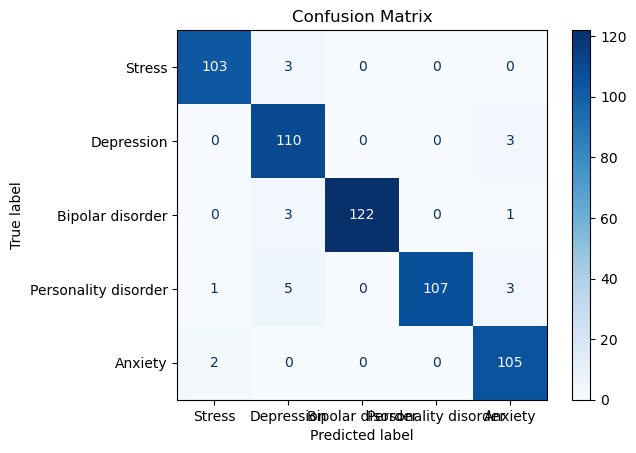

In [18]:
class_names = [
    "Stress",
    "Depression",
    "Bipolar disorder",
    "Personality disorder",
    "Anxiety"
]

# Generate and display the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()